Objectif : être en mesure de prédire un nombre de personnes venant à une maraude sur une jour précis, dans un arrondissement précis.

In [ ]:
import pandas as pd 
from datetime import timedelta
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

df = pd.read_csv("../data/utilisateur_maraude_feedback.csv", delimiter=",")

In [146]:
df.head()

,uuid,datetime,borough,theme,message,user_days
0,42e9009a-8706-498d-be3b-94f48e299da2,2025-05-31T16:42:29.308241,13,maraude,Y a-t-il une distribution de repas prévue aujo...,NaN
1,66f5ccd4-b0e1-47c9-9237-3cd5c2f46c2b,2025-05-31T16:47:48.848388,13,maraude,Y a-t-il une distribution de repas prévue aujo...,NaN
2,27ee44f4-6e97-42ea-9162-a68e0dba79b8,2025-05-31T17:00:19.509599,13,maraude,Y a-t-il une distribution de repas prévue dans...,"Lundi, Jeudi"
3,6a4a6ac9-cce7-4cc5-8f23-7ff7aa400b3c,2025-05-31T17:02:17.732715,13,maraude,Y a-t-il une distribution de repas prévue dans...,NaN
4,494d493d-4760-4f16-ab5e-ef8f19295a92,2025-05-31T17:02:28.878320,13,maraude,Y a-t-il une distribution de repas prévue dans...,"Lundi, Jeudi"


In [147]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5010 entries, 0 to 5009
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   uuid       5010 non-null   object
 1   datetime   5010 non-null   object
 2   borough    5010 non-null   int64 
 3   theme      5010 non-null   object
 4   message    5010 non-null   object
 5   user_days  3733 non-null   object
dtypes: int64(1), object(5)
memory usage: 235.0+ KB


In [148]:
df.isna().value_counts()

uuid   datetime  borough  theme  message  user_days
False  False     False    False  False    False        3733
                                          True         1277
Name: count, dtype: int64

In [149]:
df = df[df["user_days"].notna()]

# df = df.dropna(subset=["user_days"])

In [150]:
df.head()


,uuid,datetime,borough,theme,message,user_days
2,27ee44f4-6e97-42ea-9162-a68e0dba79b8,2025-05-31T17:00:19.509599,13,maraude,Y a-t-il une distribution de repas prévue dans...,"Lundi, Jeudi"
4,494d493d-4760-4f16-ab5e-ef8f19295a92,2025-05-31T17:02:28.878320,13,maraude,Y a-t-il une distribution de repas prévue dans...,"Lundi, Jeudi"
5,f1fa0180-a028-461e-9db8-24f08204fedf,2025-06-01T13:57:57.113901,13,maraude,Y a-t-il une distribution de repas prévue dans...,"Lundi, Jeudi"
7,3872f4ef-9402-453f-80c0-f7dabfbdde98,2025-06-01T14:04:11.552334,13,maraude,Y a-t-il une distribution de repas prévue dans...,"Lundi, Jeudi"
10,4bf98d58-3bc2-4be6-9c08-f61b8a530160,2025-06-01T15:03:37.452516,14,maraude,Y a-t-il une distribution de repas aujourd'hui ?,"Vendredi, Mardi, Mercredi"


In [151]:
# On suppose ici que si un utilisateur déclaire le 04/06/2025 qu'il vient aux maraudes du 3ème arrondissement les ludni et mardi, les seules valeurs que nous retiendrons seront le lundi et mardi suivants cette date, soient les 09 et 10 juin 2025. 
# Pour s'assurer de la qualité des données, on ne retiendra pas les lundis et mardis suivants.
# On doit donc, dans notre dataframe, matcher les jours de la semaines avec les dates réelles.


def days_to_dates(message_date, user_days):
    # On convertit les jours de la semaine en index (0 = lundi, ..., 6 = dimanche)
    jours_map = {"Lundi": 0, "Mardi": 1, "Mercredi": 2, "Jeudi": 3, "Vendredi": 4, "Samedi": 5, "Dimanche": 6}
    
    semaine_debut = message_date - timedelta(days=message_date.weekday()) 
    
    result = []
    for jour in user_days:
        jour = jour.strip()
        if jour in jours_map:
            date_du_jour = semaine_debut + timedelta(days=jours_map[jour])
            result.append({"date": date_du_jour.date(), "jour": jour})
    return result


In [152]:
df["datetime"] = pd.to_datetime(df["datetime"])
df["user_day_list"] = df["user_days"].str.split(",")

df_exploded = df.explode("user_day_list")
df_exploded["user_day_list"] = df_exploded["user_day_list"].str.strip()

daily_rows = []

for _, row in df_exploded.iterrows():
    matches = days_to_dates(row["datetime"], [row["user_day_list"]])
    for match in matches:
        daily_rows.append({
            "uuid": row["uuid"],
            "declared_at": row["datetime"].date(),
            "date": match["date"],
            "jour_semaine": match["jour"],
            "borough": row["borough"]            
        })

df_daily = pd.DataFrame(daily_rows)


In [153]:
df_daily.head()

,uuid,declared_at,date,jour_semaine,borough
0,27ee44f4-6e97-42ea-9162-a68e0dba79b8,2025-05-31,2025-05-26,Lundi,13
1,27ee44f4-6e97-42ea-9162-a68e0dba79b8,2025-05-31,2025-05-29,Jeudi,13
2,494d493d-4760-4f16-ab5e-ef8f19295a92,2025-05-31,2025-05-26,Lundi,13
3,494d493d-4760-4f16-ab5e-ef8f19295a92,2025-05-31,2025-05-29,Jeudi,13
4,f1fa0180-a028-461e-9db8-24f08204fedf,2025-06-01,2025-05-26,Lundi,13


In [154]:
# On ne garde que les données que déclarées sur les 30 derniers jours calendaires pour une question de qualité de la prédiction

aujourdhui = pd.to_datetime(datetime.today())
date_limite = aujourdhui - pd.DateOffset(months=1)

df_daily["declared_at"] = pd.to_datetime(df_daily["declared_at"])
df_recent = df_daily[df_daily["declared_at"] >= date_limite]



In [155]:
df_agg = df_daily.groupby(["date", "jour_semaine", "borough"]).size().reset_index(name="nb_personnes")


In [156]:
df_agg.head()

,date,jour_semaine,borough,nb_personnes
0,2025-02-03,Lundi,1,2
1,2025-02-03,Lundi,2,2
2,2025-02-03,Lundi,3,1
3,2025-02-03,Lundi,4,2
4,2025-02-03,Lundi,5,2


In [157]:
# On ajoute des features à notre dataframe

df_agg["jour_num"] = pd.to_datetime(df_agg["date"]).dt.weekday       # 0 = Lundi, ..., 6 = Dimanche
df_agg["semaine"] = pd.to_datetime(df_agg["date"]).dt.isocalendar().week
df_agg["mois"] = pd.to_datetime(df_agg["date"]).dt.month
df_agg["annee"] = pd.to_datetime(df_agg["date"]).dt.year

In [158]:
# On crée les jeux d'entrainement et de test

X = df_agg[["jour_num", "semaine", "mois", "annee", "borough"]]
y = df_agg["nb_personnes"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [159]:
X_train.shape

(1308, 5)

In [163]:
y_test.shape

(327,)

In [161]:
# On entraîne notre modèle Random Forest

model = RandomForestRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("MAE :", mean_absolute_error(y_test, y_pred))


MAE : 1.283119266055046


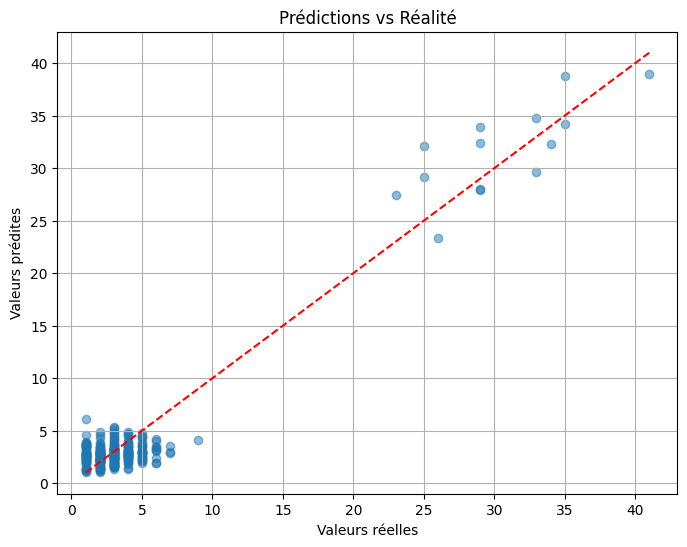

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # ligne y = x
plt.xlabel("Valeurs réelles")
plt.ylabel("Valeurs prédites")
plt.title("Prédictions vs Réalité")
plt.grid(True)
plt.show()

In [ ]:
# On peut maintenant réaliser des prédictions pour évaluer le nombre de personnes qui viendraient sur une maraude sur jour en particulier.
# LEs données en entrée : date et arrondissement.

# On entre nos valeurs pour la prédiction
date = pd.to_datetime("2025-06-09") 
borough = 13

X_new = pd.DataFrame([{
    "jour_num": date.weekday(),             
    "semaine": date.isocalendar().week,             
    "mois": date.month,
    "annee": date.year,
    "borough": borough
}])

prediction = model.predict(X_new)[0]
print(f"Prédiction pour le {date.date()} à Paris {borough} : {prediction:.0f} personne(s) attendue(s)")



Prédiction pour le 2025-06-09 à Paris 13 : 1 personnes attendue(s)
